## Download the data:

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
!mkdir data
!unzip house-prices-advanced-regression-techniques.zip -d data

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder


# Since the dataset has a large number of features, it's best to let Pandas display all the columns of the dataframe
pd.options.display.max_columns = None
# Turn off Future Warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read the data

In [ ]:
# Read the training data
train_df = pd.read_csv("data/train.csv")
# Read the test data
test_df = pd.read_csv("data/test.csv")
train_df.head()

## Reading the description file provided by Kaggle.

Since our datasets came with a description file, it's best to review that quickly and get a sense of the features. This will help guide the analysis. 

In [ ]:
desc = open("data/data_description.txt")
txt = desc.read()
print(txt)
desc.close()

In [ ]:
# Saving the the ID column for both train and test
train_Id = train_df['Id']
test_Id = test_df['Id']

In [ ]:
print("There are {} rows in the training dataframe".format(train_df.shape[0]))
print("There are {} features in the training dataframe".format(train_df.shape[-1]))
print("There are {} rows in the testing dataframe".format(test_df.shape[0]))

In [ ]:
train_df.describe()

In [ ]:
train_df.info()

#### Quantatitive Variables: 

In [ ]:
quant_feat = list(train_df.dtypes[train_df.dtypes != "object"].index)
quant_feat

#### Qualatative Variables: 

In [ ]:
qual_feat = list(train_df.dtypes[train_df.dtypes == "object"].index)
qual_feat

### Target Variable: 
In this section, I am creating a helper function that will help visualize the distribution of features. 

In [ ]:
def draw_distribution(df, col, **options):
    """
    This function helps draw a distribution plot for the desired colum.
    Input args: 
    1. df : Dataframe that we want to pick the column from. 
    2. col : Column of the dataframe that we want to display.
    3. options:
        a. kde : optional, boolian - Whether to plot a gaussian kernel density estimate.
        b. fit : An object with `fit` method, returning a tuple that can be passed to a `pdf` method a 
        positional arguments following a grid of values to evaluate the pdf on.
    """
    plt.figure(figsize=(12,10))
    plt.ylabel("Frequency")
    plt.title("{} Distribution".format(col))
    if options.get("kde")==True:
        sns.distplot(df[col], kde=True, color="#2b7bba");
    if options.get("fit")== "norm":
        (mu, sigma) = norm.fit(df[col])
        sns.distplot(df[col], fit=norm, color="#2b7bba");
        plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
                  loc='best');
        
    if (options.get("fit")== "norm") & (options.get("kde")==True):
        sns.distplot(df[col], fit=norm, kde=True, color="#2b7bba");
    else:
        sns.distplot(df[col], color="#2b7bba");

In [ ]:
# Let's plot a distribution plot for the target variable column and see how the prices are distributed. 
draw_distribution(train_df, "SalePrice", kde=True)

In [ ]:
draw_distribution(train_df, "SalePrice",fit="norm", kde=True)

In [ ]:
## QQ Plot
fig  = plt.figure(figsize=(12,10))
stats.probplot(train_df["SalePrice"], plot=plt)
plt.show();

We can see that the prices are slightly skewed to the right and centered $200,000. Let's run a descriptive statistics on our target variable.

In [ ]:
train_df["SalePrice"].describe()

As we can see, most of the house prices are below the 75 percentile. One way to fix this by using a logarithmic scale.

#### Log Transformation of the target variable

In [ ]:
df_scaled = train_df.copy()
#I am usin log1p  function from np which  applies log(1+x) to all elements of the column
df_scaled["SalePrice"] =  np.log1p(train_df["SalePrice"])

In [ ]:
# Plotting the 
draw_distribution(df_scaled, "SalePrice",fit="norm", kde=True)

In [ ]:
## QQ Plot
fig  = plt.figure(figsize=(12,10))
stats.probplot(df_scaled["SalePrice"], plot=plt)
plt.show();

### Missing Values:
In this section, I am going to look into the missing values and come up with the strategies that could help fix those. It's recommended to see if the missing values are random or they an underlying pattern.

In [ ]:
# Counting the missing values per feature and picking the top 25
missing_values = df_scaled.isnull().sum().sort_values(ascending=False)[:25]
# Calculating the missing ratio and picking the top 25
ratio = ((df_scaled.isnull().sum()/df_scaled.isnull().count())*100).sort_values(ascending=False)[:25]
missing_data = pd.concat([missing_values, ratio], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head(20)

Let's visualize these for better understanding; 

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
plt.title("Missing values Ratio per Feature")
plt.xlabel("Features")
plt.ylabel("Percent of missing values")
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=ratio);

In [ ]:
def transform_1_impute_missing(df):
    # Per the data description, the NA in the PoolQC column means the house did not have a pool. We can impute that with "None"
    df["PoolQC"] = df["PoolQC"].fillna("None")
    # MiscFeature. The description says that NA means No Misc Feature
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    # Alley
    df["Alley"] = df["Alley"].fillna("None")
    # Fence
    df["Fence"] = df["Fence"].fillna("None")
    # FireplaceQu
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    # LotFrontage: For this we cannot use None. Everyhouse "should" have front in the use. 
    # Since houses are most probably similar in each neighborhoods, we can impute the missing values by the median of each 
    # neighborhood. 
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x:
                                                                            x.fillna(x.median()))
    # GarageCond, GarageType, GarageYrBlt
    df[["GarageCond", "GarageType", "GarageQual", "GarageFinish"]] = df[["GarageCond",
                                                                         "GarageType", 
                                                                         "GarageQual",
                                                                         "GarageFinish"]].fillna("None")
    # We will impute the following with 0 since they are quntatitive. 
    df[["GarageArea", "GarageCars", "GarageYrBlt"]] = df[["GarageArea",
                                                          "GarageCars", 
                                                          "GarageYrBlt"]].fillna(0)

    # The following numerical features are related to baseemnt and we can replace NaNs with 0 since 
    # NaN means zero basement
    for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
        df[col] = df[col].fillna(0)
    # The following categorical features are related to basement and we can replace the NAs with Non since NaN mean 
    # no basement
    for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
        df[col] = df[col].fillna("None")
    #  MasVnrType: to None
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    # MasVnrType to 0   : Having NaN in the Veneer area means 0 veneer
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    # MSZonming: After looking at the zoning informationk, we can see that "RL" is the most common value. 
    # We can use that to impute The missing zones. 
    df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])
    # Exterior1st: Impute with most common value:
    df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
    # Exteriror2nd: Impute with most common value:
    df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
    # Utilities : Since most of the values in the dataframe for Utilities is "AllPub", we can drop 
    # this feature without affecting our model. We will drop it later in the feature engineering phase
    # Fucntional: NA means typical
    df["Functional"] = df["Functional"].fillna("Typ")
    # Electrical : We can impute this with the most common value which is "SBrkr"
    df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])
    # Kitchen Qual : we can impute this with the most common value which is "TA"
    df["KitchenQual"] = df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])
    # MSSubClass : Impute with None
    df["MSSubClass"] = df["MSSubClass"].fillna("None")
    # SaleType: Impute with the most common value which is "WD"
    df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])

    return df

In [ ]:
df_scaled = transform_1_impute_missing(df_scaled)

In [ ]:
# Double check to make sure all the missing values are imputed: 
# Counting the missing values per feature and picking the top 25
missing_values = df_scaled.isnull().sum().sort_values(ascending=False)[:25]
# Calculating the missing ratio and picking the top 25
ratio = ((df_scaled.isnull().sum()/df_scaled.isnull().count())*100).sort_values(ascending=False)[:25]
missing_data = pd.concat([missing_values, ratio], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head(5)

## Correlation

In [ ]:
#Using Pearson Correlation
#plt.figure(figsize=(12,10))
# Calculate the correlation on the entire dataframe
cor = df_scaled.corr()
# Create a mask to hight the cells above the diagonal line. 
mask = np.triu(np.ones_like(cor, dtype=bool))
# Setting up the figure
f, ax = plt.subplots(figsize=(14, 12))
# Create a custom color pallete
cmap = cmap = sns.cm.vlag_r
# Draw the heatmap with the mask. 
sns.heatmap(cor, annot=False, mask=mask, square=True, linewidths=.4, 
            vmax=1, center=0, cmap=cmap);
plt.show();

As we can see from the heatmap above, we could see multicollinearity among features. For example, there is avery high correlation between GarageYrBlt and YearBuilt, or GarageCars and GarageArea. 

In the following section, I want to define a function that helps us narrow down our heatmap to the top n highly correlated variables that we want to display. 

In [ ]:
def draw_heatmap(df, y_variable, no_features):
    """ This Function takes three arguments; 
        1. The dataframe that we want to draw the heatmap for
        2. The variable that we want to see the correlation of with other features for example the y-variable.
        3. The top_n. For example for top 10 variables, type 10."""
    # Calculate the correlation matrix
    cor = df.corr()
    # Get the columns for n largetst features
    columns = cor.nlargest(no_features, y_variable)[y_variable].index
    cm = np.corrcoef(df[columns].values.T)
    sns.set(font_scale=1)
    fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    # Define the color pallet
    cmap = sns.cm.vlag_r
    heat_map = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size':12}, 
                      yticklabels=columns.values, xticklabels=columns.values,
                      linewidths=.2,vmax=1, center=0, cmap= cmap)
    return plt.show();

In [ ]:
# Let's see the top 10 features against "SalePrice"
draw_heatmap(df_scaled, "SalePrice", 10)

In [ ]:
# Let's see the top 5 variables: 
draw_heatmap(df_scaled, "SalePrice", 5)

I want to check for multicollinearity between features that are about the same thigns for exmaple, Garage, or basement. 

In [ ]:
basement_features =     ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath",
                         "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "SalePrice"]
bsmnt_df = df_scaled[basement_features]
draw_heatmap(bsmnt_df, "SalePrice", 10)

As we can see the features are somehow correlated, but I don't think they will affect the model. 
I am going to use the TotalBsmtSF later to create another feature and will drop it.

Let's check for the features of Garage: 

In [ ]:
garage_features = ["GarageCond","GarageType", "GarageQual","GarageFinish", "GarageArea","GarageCars","GarageYrBlt", "SalePrice"]
garage_df = df_scaled[garage_features]
draw_heatmap(garage_df, "SalePrice", 10)

In [ ]:
corr, _ = pearsonr(df_scaled["GarageArea"], df_scaled["GarageCars"])
print('Pearsons correlation: %.3f' % corr)

I am going to use the GarageArea in to create another variable and will drop it from the dataframe, so I don't have to worry about multicollinearity

## Feature Engineering:

In this section I am going to create some new features and maybe delete some features that won't affect our model: 

In [207]:
def transform_2_encode_data(df):
    """
    Since most of of our features are ordinal categorical, we cannot use one hot encodeing or Pandas' get_dummies function here. 
    Instead, we are going to code them manualy so there is an order to the values. 
    """
    # Convert the following columns  according to their dictionary. 
    df['MSSubClass'] = df["MSSubClass"].replace(
     {20: 'SC20',30: 'SC30', 40: 'SC40', 45: 'SC45', 50: 'SC50', 60: 'SC60', 70: 'SC70', 75: 'SC75',
      80: 'SC80', 85: 'SC85', 90: 'SC90', 120: 'SC120', 150: 'SC150', 160: 'SC160', 180: 'SC180', 190: 'SC190'})
    #pd.get_dummies(df['MSSubClass'], prefix='MSSubClass')
    df = df.replace({'Street': {'Grvl': 0, 'Pave': 1},
                     'Alley': {'None':0, 'Grvl': 1, 'Pave': 2},
                     'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
                     'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
                     'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'None': 0},
                     'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'None': 0},
                     'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'None': 0},
                     'BsmtFinType1': {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                     'BsmtFinType2': {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
                     'CentralAir': {'N':0, 'Y':1},
                     'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
                     'Functional': {'Typ':0,'Min1':1,'Min2':1,'Mod':2,'Maj1':3,'Maj2':4,'Sev':5,'Sal': 6},
                     'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
                     'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
                     'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
                     'GarageFinish': {'Fin': 3, 'RFn':2, 'Unf':1, 'None':0},
                     'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0},
                     'Fence': {'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1, 'None': 0},
                     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
                     'LotShape' : {'Reg': 3, 'IR1':2, 'IR2':1, 'IR3':0},
                     'LandSlope': {'Gtl': 2, 'Mod':1, 'Sev':0}
                      })
    # Convert the Neighborhoods to latitude and longtitude
    dict_neighbor = {
        'NAmes'  :{'lat': 42.045830,'lon': -93.620767},
        'CollgCr':{'lat': 42.018773,'lon': -93.685543},
        'OldTown':{'lat': 42.030152,'lon': -93.614628},
        'Edwards':{'lat': 42.021756,'lon': -93.670324},
        'Somerst':{'lat': 42.050913,'lon': -93.644629},
        'Gilbert':{'lat': 42.060214,'lon': -93.643179},
        'NridgHt':{'lat': 42.060357,'lon': -93.655263},
        'Sawyer' :{'lat': 42.034446,'lon': -93.666330},
        'NWAmes' :{'lat': 42.049381,'lon': -93.634993},
        'SawyerW':{'lat': 42.033494,'lon': -93.684085},
        'BrkSide':{'lat': 42.032422,'lon': -93.626037},
        'Crawfor':{'lat': 42.015189,'lon': -93.644250},
        'Mitchel':{'lat': 41.990123,'lon': -93.600964},
        'NoRidge':{'lat': 42.051748,'lon': -93.653524},
        'Timber' :{'lat': 41.998656,'lon': -93.652534},
        'IDOTRR' :{'lat': 42.022012,'lon': -93.622183},
        'ClearCr':{'lat': 42.060021,'lon': -93.629193},
        'StoneBr':{'lat': 42.060227,'lon': -93.633546},
        'SWISU'  :{'lat': 42.022646,'lon': -93.644853}, 
        'MeadowV':{'lat': 41.991846,'lon': -93.603460},
        'Blmngtn':{'lat': 42.059811,'lon': -93.638990},
        'BrDale' :{'lat': 42.052792,'lon': -93.628820},
        'Veenker':{'lat': 42.040898,'lon': -93.651502},
        'NPkVill':{'lat': 42.049912,'lon': -93.626546},
        'Blueste':{'lat': 42.010098,'lon': -93.647269}
        }
    df["Lat"] = df["Neighborhood"].map(lambda x: dict_neighbor[x]['lat'])
    df["lon"] = df["Neighborhood"].map(lambda x: dict_neighbor[x]['lon'])
    df.drop(["Neighborhood"], axis=1, inplace=True)

    # Cols that need to be encoded using LabelEncoder: 
    df["OverallCond"] = df["OverallCond"].astype(int)
    df["ExterQual"] = df["ExterQual"].astype(int)
    df["KitchenQual"] = df["KitchenQual"].astype(int)
    df["Functional"] = df["Functional"].astype(int)

    
    cols = ('PavedDrive','OverallCond', 'YrSold', 'MSZoning', 'LandContour', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'GarageType', 'LotConfig', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
           'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'Electrical', 'MiscFeature',
           'SaleType','SaleCondition' )
    
    for column in cols:
        label = LabelEncoder()
        label.fit(list(df[column].values))
        df[column] = label.transform(list(df[column].values))
        
    # Now that we have the list of ordinal categories encoded, we can use Panda's get_dummy function to 
    # convert the rest to dummy variable. 
    #df = pd.get_dummies(df)
    
    return df

In [ ]:
def transform_3_simplify_and_create_features(df):
    """ In the section, we are going to create create some new features from the existing features and then drop the 
    features that we don't need anymore."""
    df = df.drop(["Id"], axis=1)
    
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    df["MoSold"] = df["MoSold"].astype(str)
    df["YrSold"] = df["YrSold"].astype(str)
    
    # Create dummy variable for MoSold and MSSubClass variables. 
    df = pd.concat([df, pd.get_dummies(df["MoSold"], prefix='MoSold')], axis=1)
    df = pd.concat([df, pd.get_dummies(df["MSSubClass"], prefix='MSSubClass')], axis=1)

    # Adding a column for the total squqre footage. We can calculate this by taking the sum of all possible areas
    # which could be the sum of total basement, 1st floor and 2nd floor areas
    df["TotalSqF"] = (df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"] +
                        df["GarageArea"] + df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["PoolArea"])
    # Total number of bathrooms
    df["TotalBaths"] = (df["HalfBath"] + (0.5 * df["FullBath"]) + 
                        df["BsmtFullBath"] + (0.5*df["BsmtHalfBath"]))
    
    # Total Porch Square Feet
    df['TotalPorchSF'] = (df["OpenPorchSF"] + df["3SsnPorch"] +
                              df["EnclosedPorch"] + df["ScreenPorch"] +
                              df["WoodDeckSF"])
    # Let's get the current year first
    current_year = int(datetime.now().strftime('%Y'))
    
    # House Age
    # Now let's subract the year built from the current year variable to caculate the age of the hosue
    df["HouseAge"] = current_year - df["YearBuilt"]

    # House Remodeling Age
    df["RemodAddAge"] = current_year - df["YearRemodAdd"]
    
    # Garage AGe
    df["GarageAge"] = current_year - df["GarageYrBlt"]
    
    
    df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1, 6 : 1,7 : 1, # Not Good
                                                     8 : 3, 9 : 3, 10 : 3 # good
                                                    })
    df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, 5 :1, 6 : 1, 7: 1,  # Not Good
                                                     8 : 2, 9 : 2, 10 : 2 # good
                                                    }).astype(int)
    df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, 3: 1, # Not Good
                                           4 : 2 # good
                                          }).astype(int)
    df["SimplGarageCond"] = df.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                   5 : 2 # good
                                                  }).astype(int)
    df["SimplGarageQual"] = df.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                   5 : 2 # good
                                                  }).astype(int)
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                     5 : 2 # good
                                                    })
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                     5 : 2 # good
                                                    }).astype(int)
    df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, # bad
                                                   3 : 2, 4 : 2, # major
                                                   5 : 3, 6 : 3, 7 : 3, # minor
                                                   8 : 4 # typical
                                                  })
    df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                     5 : 2 # good
                                                    })
    df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                 5 : 2 # good
                                                })
    df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                      }).astype(int)
    df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                      })
    df["SimplBsmtCond"] = df.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                               5 : 2 # good
                                              })
    df["SimplBsmtQual"] = df.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                               5 : 2 # good
                                              })
    df["SimplExterCond"] = df.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                 5 : 2 # good
                                                })
    df["SimplExterQual"] = df.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # Not Good
                                                 5 : 2 # good 
                                                })
    df["OverallQual-s2"] = df["OverallQual"] ** 2
    df["OverallQual-s3"] = df["OverallQual"] ** 3
    df["GrLivArea-2"] = df["GrLivArea"] ** 2
    df["GrLivArea-3"] = df["GrLivArea"] ** 3
    df["SimplOverallQual-s2"] = df["SimplOverallQual"] ** 2
    df["SimplOverallQual-s3"] = df["SimplOverallQual"] ** 3
    df["SimplOverallQual-Sq"] = np.sqrt(df["SimplOverallQual"])
    df["ExterQual-2"] = (df["ExterQual"]).astype(int) ** 2
    df["ExterQual-3"] = df["ExterQual"] ** 3
    df["ExterQual-Sq"] = np.sqrt((df["ExterQual"].astype(int)))
    df["GarageCars-2"] = df["GarageCars"] ** 2
    df["GarageCars-3"] = (df["GarageCars"] ** 3).astype(int)
    df["GarageCars-Sq"] = np.sqrt(df["GarageCars"])
    df["TotalBath-2"] = df["TotalBaths"] ** 2
    df["TotalBath-3"] = df["TotalBaths"] ** 3
    df["TotalBath-Sq"] = np.sqrt(df["TotalBaths"])
    df["KitchenQual-2"] = (df["KitchenQual"] ** 2).astype(int)
    df["KitchenQual-3"] = (df["KitchenQual"] ** 3).astype(int)

    #drop the columns used to generate other columns. 
    df.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GarageArea", "BsmtFinSF1", 
             "BsmtFinSF2", "HalfBath", "FullBath", "BsmtFullBath", "BsmtHalfBath",
            "OpenPorchSF", "3SsnPorch", "EnclosedPorch", "ScreenPorch", "WoodDeckSF",
            "YearBuilt","YearRemodAdd", "GarageYrBlt", "YrSold", 'MoSold', 'MSSubClass', "Utilities"], axis=1, inplace=True)
    return df

## Transforming the data:
In this section, I am going to apply the functions that we created earlier to transform the train and test data and prepare them for our Machine Learning algorithms. 

In [ ]:
# This helper function is going to help us apply the functions in order and return a prepared dataframe. 
def full_transform(df):
    return transform_3_simplify_and_create_features(transform_2_encode_data(transform_1_impute_missing(df)))

In [ ]:
train_data = full_transform(train_df)
# Rescale the target variable
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
test_data = full_transform(test_df)

Let's check and make sure that both the training and testing data have the same elements.

In [ ]:
print("Columns from the train data that are not in test ", train_data.columns.difference(test_data.columns))
print("Columns from the test data that are not in train ", test_data.columns.difference(train_data.columns))

In [ ]:
# We should drop that MSSubClass_SC150 column from test data: 
test_data = test_data.drop(['MSSubClass_SC150'], axis=1)

In [ ]:
print("Columns from the train data that are not in test ", train_data.columns.difference(test_data.columns))
print("Columns from the test data that are not in train ", test_data.columns.difference(train_data.columns))

In [ ]:
# Let's check the heatmap for the transformed data. 
draw_heatmap(train_data, "SalePrice", 15)

### Exploring the relationship between the highest correlated features and the SalePrice

Now that we know our top 5 highly correlated features, let's draw a scatter plot for some of the features to see how the data is distributed and if we could observe any outliers. 

Since I am going to be displaying the relationship between several columns, I am going to define a function that will help us do that. 

In [208]:
def draw_scatter(df, x, y="SalePrice"):
    """ This fuction helps draw a scatter plot using Seaborn's functions. 
    It takes three input arguements:
    1. The dataframe(data)
    2. our x variable that we want to display in our x axis
    3. y variable. The default column is 'SalePrice', however, we can change that 
    to whatever column we want"""
    # Set the fiture size
    plt.figure(figsize=(12,10))
    # plot the variables
    sns.scatterplot(data=df, x=x, y=y, palette="deep").set_title("Scatter Plot for {} vs. {}".format(x, y))

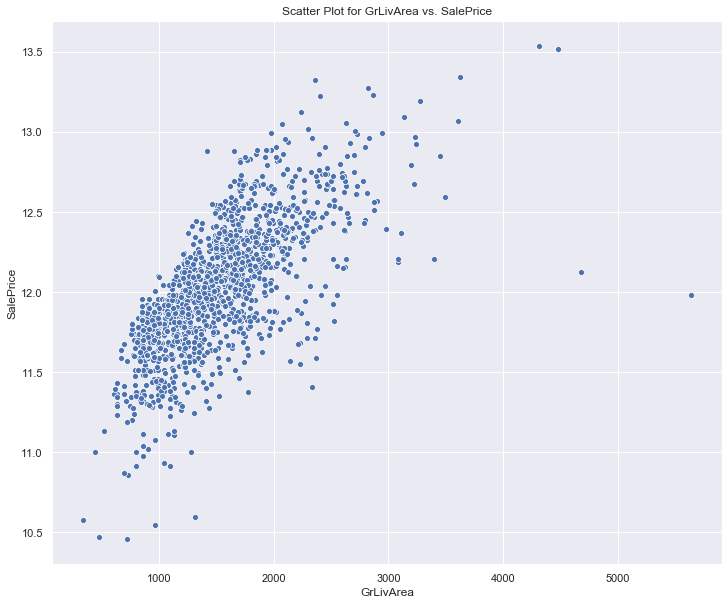

In [209]:
# Let's look at the relationship between GrLivArea and the SalePrice
draw_scatter(df_scaled, "GrLivArea")

We can see that there are a few points to the very right of the graph. I assume they are outliers. Let's draw a boxplot and confirm if those points are really outliers:

## Modeling

Now that we have our data prepared, let's start our modeling process. 


### Libraries
Importing libraries that will be used:

In [210]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer 
from scipy.stats import uniform
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

### Preparing the data for the model: 

In [211]:
# Copying our transformed data
data = train_data.copy()
#Splitting the data into feature and target varaibles. 
housing = data.drop("SalePrice", axis=1) # drop labels for training set
housing_labels = data["SalePrice"].copy()

# Prepare our training data into train test portions. 
X_train, X_test, y_train, y_test = train_test_split(housing, housing_labels, test_size = 0.35,
                                                   random_state = 123)

# Feature Selection

Now that we have our data prepared, we should perform feature selection to reduce the number of features. We can see that we 130 features. Feature selection is going to help us improve performance and also reduce CPU runtime. 

### Feature Selection Using XGBoost

In [96]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
feature_importances = imp.sort_values(by='Importance',ascending=False)
feature_importances.head(32)

,Importance
KitchenQual,0.138899
OverallQual,0.120414
CentralAir,0.084872
TotalSqF,0.083853
GarageType,0.077574
MSSubClass_SC30,0.046141
GrLivArea,0.034454
GarageCars,0.024165
SaleCondition,0.022419
RemodAddAge,0.021911


### Feature Importance Using Random Forest Regressor

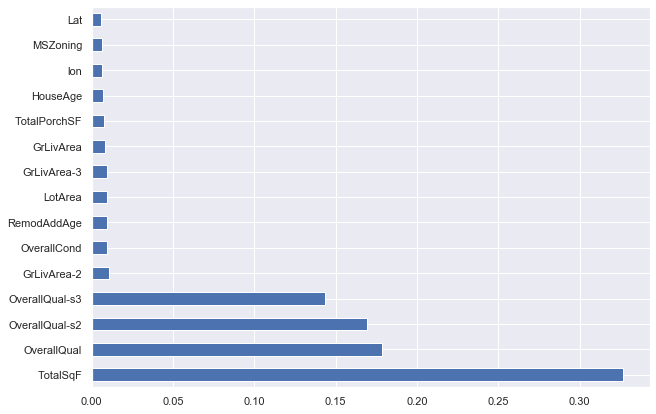

In [99]:
rfr_model = RandomForestRegressor(max_depth=10)
rfr_model.fit(X_train, y_train)

# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rfr_model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### Feature Importance using RFEC (Recursive feature elimination and cross-validated selection)

In [ ]:
# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

neg_rmse = make_scorer(nrmse)

estimator = XGBRegressor()
selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
selector = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = X_train.columns.values[selector.support_] 

X_train = X_train[features_kept]
X_test = X_test[features_kept]

features_kept

In [83]:
# Features Kept
feature_kept = ['MSZoning', 'LotFrontage', 'LotArea', 'Condition1', 'OverallQual', 'OverallCond', 
                'Exterior1st', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'CentralAir', 
                'LowQualFinSF', 'GrLivArea', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 
                'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'SaleCondition', 'Lat', 'lon', 
                'MSSubClass_SC30', 'TotalSqF', 'TotalBaths', 'TotalPorchSF', 'HouseAge', 'RemodAddAge', 'GarageAge']

In [85]:
X_train1 = X_train[feature_kept]
X_test1 =  X_test[feature_kept]

# Removing Outliers

In [192]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75]) #Get 1st and 3rd quartiles (25% -> 75% of data will be kept)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) #Get lower bound
    upper_bound = quartile_3 + (iqr * 1.5) #Get upper bound
    return np.where((ys > upper_bound) | (ys < lower_bound)) #Get outlier values

#Third, we will drop the outlier values from the train set
newTrain = train_data.copy()
trainWithoutOutliers = newTrain #We can't change train while running through it

for column in newTrain:
    outlierValuesList = np.ndarray.tolist(outliers_iqr(newTrain[column])[0]) #outliers_iqr() returns an array
    trainWithoutOutliers = newTrain.drop(outlierValuesList) #Drop outlier rows
    
trainWithoutOutliers = newTrain

# Building and Training the Models

First, I am going to run a regular Gridsearch 
#### Using Basic Regression Models

In [136]:
def test_models(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[feature_kept], 
                                                                data["SalePrice"], 
                                                                test_size= 0.2)
            r2_test.append(mean_squared_error(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(mean_squared_error(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [140]:
# Parameters for Lasso and Ridge Regression Models. 
lasso_params = {'alpha':[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.01]}
ridge_params = {'alpha':[14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5, 16, 20, 30, 31, 32, 35, 38, 40, 50]}

# Defining our Models and fitting them on the training data. 
models2 = {'OLS': LinearRegression(),
           'Lasso': GridSearchCV(Lasso(), 
                               param_grid=lasso_params).fit(X_train1, y_train).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params).fit(X_train1, y_train).best_estimator_,}

In [141]:
test_models(models2, train_data)

,OLS,Lasso,Ridge
0,0.019607,0.019558,0.020185
1,0.024889,0.025196,0.023315


#### Using Cross Validation and Stacking Models

In [186]:
from sklearn.svm import SVR
from lightgbm import  LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train1, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5, 16, 20, 30, 40, 50]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.01]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ols = make_pipeline(RobustScaler(), LinearRegression())
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

stack_gen = StackingCVRegressor(regressors=(ols, ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [187]:
score = cv_rmse(ols)
print("OLS: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

OLS: 0.1548 (0.0599)
 2020-09-27 00:02:12.862336


In [149]:
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

RIDGE: 0.1533 (0.0580)
 2020-09-26 23:04:07.360220


In [150]:
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1551 (0.0607)
 2020-09-26 23:04:10.829679


In [151]:
score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

elastic net: 0.1550 (0.0604)
 2020-09-26 23:04:14.699625


In [152]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

SVR: 0.1592 (0.0509)
 2020-09-26 23:04:16.601151


In [153]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [154]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

gbr: 0.1240 (0.0159)
 2020-09-26 23:05:23.384815


In [159]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

xgboost: 0.1225 (0.0198)
 2020-09-26 23:06:58.900403


In [188]:
def blend_models_train(X, y):
    stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
    ols_model = ols.fit(X, y)
    elastic_model = elasticnet.fit(X, y)
    lasso_model = lasso.fit(X, y)
    ridge_model = ridge.fit(X, y)
    svr_model = svr.fit(X, y)
    gbr_model = gbr.fit(X, y)
    xgb_model = xgboost.fit(X, y)
    lgb_model = lightgbm.fit(X, y)
    return stack_gen_model, ols_model, elastic_model, lasso_model, ridge_model, svr_model, gbr_model, xgb_model, lgb_model

In [189]:
def blend_models_predict(y):
    # Here, we are going to weigth each model based on their performance during the cross validation phase
    return ((0.05 * elastic_model.predict(y)) + \
            (0.05 * lasso_model.predict(y)) + \
            (0.05 * ols_model.predict(y)) + \
            (0.1 * ridge_model.predict(y)) + \
            (0.1 * svr_model.predict(y)) + \
            (0.1 * gbr_model.predict(y)) + \
            (0.15 * xgb_model.predict(y)) + \
            (0.1 * lgb_model.predict(y)) + \
            (0.30 * stack_gen_model.predict(np.array(y))))

## Using the reduced features. 

In [190]:
(stack_gen_model, ols_model, elastic_model, lasso_model, 
 ridge_model, svr_model, gbr_model, xgb_model, lgb_model) = blend_models_train(X_train1, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [191]:
print('RMSLE score on train data:')
print(rmsle(y_test, blend_models_predict(X_test1)))

RMSLE score on train data:
0.12199268649690792


## Using all the features. 

In [180]:
from sklearn.svm import SVR
from lightgbm import  LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5, 16, 20, 30, 40, 50]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.01]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ols = make_pipeline(RobustScaler(), LinearRegression())
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

stack_gen = StackingCVRegressor(regressors=(ols, ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [181]:
(stack_gen_model, ols_model, elastic_model, lasso_model, 
 ridge_model, svr_model, gbr_model, xgb_model, lgb_model) = blend_models_train(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [184]:
print('RMSLE score on train data:')
print(rmsle(y_test, blend_models_predict(X_test)))

RMSLE score on train data:
0.12260349980970268


## Make Predictions and Submit 

In [198]:
# Make Prediction
predictions = blend_models_predict(test_data[feature_kept])

In [201]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['SalePrice'] = np.expm1(predictions)

In [202]:
submission

,Id,SalePrice
0,1461,125729.175784
1,1462,160650.578814
2,1463,189592.531168
3,1464,200040.687032
4,1465,186598.298786
...,...,...
1454,2915,88231.559493
1455,2916,86288.093899
1456,2917,148240.122382
1457,2918,111424.548553


In [205]:
submission.to_csv("data/submission.csv", index=False)

## Using gridsearch to find the optimal number of features

In [183]:
# define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X_train.shape[1]-100, X_train.shape[1]+1)]
# define the grid search
#search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
search = GridSearchCV(pipeline, grid, scoring=rmse_score, n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_train, y_train)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -0.152
Best Config: {'sel__k': 95}
>-0.166 with: {'sel__k': 29}
>-0.166 with: {'sel__k': 30}
>-0.166 with: {'sel__k': 31}
>-0.166 with: {'sel__k': 32}
>-0.165 with: {'sel__k': 33}
>-0.165 with: {'sel__k': 34}
>-0.165 with: {'sel__k': 35}
>-0.164 with: {'sel__k': 36}
>-0.163 with: {'sel__k': 37}
>-0.163 with: {'sel__k': 38}
>-0.162 with: {'sel__k': 39}
>-0.162 with: {'sel__k': 40}
>-0.162 with: {'sel__k': 41}
>-0.161 with: {'sel__k': 42}
>-0.161 with: {'sel__k': 43}
>-0.161 with: {'sel__k': 44}
>-0.162 with: {'sel__k': 45}
>-0.161 with: {'sel__k': 46}
>-0.161 with: {'sel__k': 47}
>-0.161 with: {'sel__k': 48}
>-0.160 with: {'sel__k': 49}
>-0.160 with: {'sel__k': 50}
>-0.158 with: {'sel__k': 51}
>-0.158 with: {'sel__k': 52}
>-0.156 with: {'sel__k': 53}
>-0.156 with: {'sel__k': 54}
>-0.155 with: {'sel__k': 55}
>-0.156 with: {'sel__k': 56}
>-0.155 with: {'sel__k': 57}
>-0.156 with: {'sel__k': 58}
>-0.155 with: {'sel__k': 59}
>-0.157 with: {'sel__k': 60}
>-0.156 with: {'sel__k': 61